##### It's weird that the keras preprocess_input() function for the Xception model produces very bad results compared to when the function isn't used for preprocessing the images.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import keras.backend as K
import plotly.express as px
from sklearn.metrics import classification_report
from tensorflow.keras.applications import xception, resnet50, vgg19, inception_resnet_v2

Using TensorFlow backend.


### EDA

In [120]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 30
IMAGE_TYPE = 'png'

In [121]:
# Reading data
files = tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/COVID 19/*")
files.extend(tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/NORMAL/*"))
files.extend(tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/Viral Pneumonia/*"))

In [122]:
# obtaining split sets
train_files, test_files = train_test_split(files, test_size=0.1, random_state=42)

In [123]:
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

In [124]:
if train_files[0][-3:] == 'jpg':
    IMAGE_TYPE == 'jpg'

In [125]:
normal_count = len([file for file in files if 'NORMAL' in file])
covid_count = len([file for file in files if 'COVID' in file])
pneumonia_count = len([file for file in files if 'Viral Pneumonia' in file])

In [126]:
class_distribution = pd.DataFrame({'class':['normal','viral pneumonia','covid'],
                                   'count':[normal_count, pneumonia_count, covid_count]})

In [127]:
fig = px.bar(class_distribution, x="class", y="count", title="Distribution of images")
fig.update_layout(width=800, height=300)
fig.show()

In [128]:
train_normal_count = len([file for file in train_files if 'NORMAL' in file])
train_covid_count = len([file for file in train_files if 'COVID 19' in file])
train_pneumonia_count = len([file for file in train_files if 'Viral Pneumonia' in file])

print(train_normal_count, train_covid_count, train_pneumonia_count)

957 874 966


In [129]:
# converting to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

In [130]:
TRAIN_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()
VAL_SIZE = tf.data.experimental.cardinality(val_dataset).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_dataset).numpy()

In [131]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE

(2797, 700, 389)

In [132]:
'''
takes a file path as input
returns the target value for the given image
'''
def get_targets(file):
    split = tf.strings.split(file, os.path.sep)
    if split[-2] == 'COVID 19':
        return 0
    elif split[-2] == 'Viral Pneumonia':
        return 2
    else: return 1

In [133]:
'''
input: file path of image
returns a processed image along with the target
'''
def preprocess_img(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    if IMAGE_TYPE == 'png':
        img = tf.image.decode_png(img, channels=3)
    if IMAGE_TYPE == 'jpg':
        img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img, target

In [134]:
# preprocessing datasets
train_data = train_dataset.map(preprocess_img)
val_data = val_dataset.map(preprocess_img)
test_data = test_dataset.map(preprocess_img)

In [73]:
# batching test set
test_data = test_data.batch(BATCH_SIZE)

In [74]:
'''
input: number of image samples needed and a tf dataset of images
returns: normal, covid, and pneumonia images as a numpy array
'''
def images_in_class_buckets(image_count, data):
    train_normal = []
    train_pneumonia = []
    train_covid = []

    for img, target in data.take(image_count):
        if target == 0:
            train_covid.append(img.numpy())
        elif target == 1:
            train_pneumonia.append(img.numpy())
        else: train_normal.append(img.numpy())
    
    train_normal = np.array(train_normal)
    train_covid = np.array(train_covid)
    train_pneumonia = np.array(train_pneumonia)
    
    return (train_normal, train_covid, train_pneumonia)

In [41]:
train_normal, train_covid, train_pneumonia = images_in_class_buckets(300, train_data)

#### Mean pixels for images

In [42]:
'''
input: set of images
returns a mean image (pixel mean)
'''
def get_mean_img(images):
    image_mean = np.mean(images, axis=0)
    return image_mean

In [43]:
mean_normal = get_mean_img(train_normal)
mean_covid = get_mean_img(train_covid)
mean_pneumonia = get_mean_img(train_pneumonia)

In [44]:
def show_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

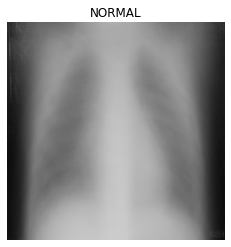

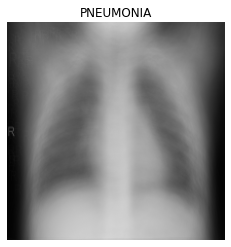

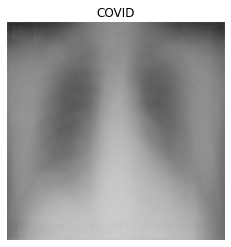

In [45]:
show_image(mean_normal, 'NORMAL')
show_image(mean_pneumonia, 'PNEUMONIA')
show_image(mean_covid, 'COVID')

#### Variability in pixels

In [46]:
'''
input: set of images
returns an image that indicates the standard deviation
across all images
'''
def get_stdev_img(images):
    image_dev = np.std(images, axis=0)
    return image_dev

In [47]:
dev_normal = get_stdev_img(train_normal)
dev_covid = get_stdev_img(train_covid)
dev_pneumonia = get_stdev_img(train_pneumonia)

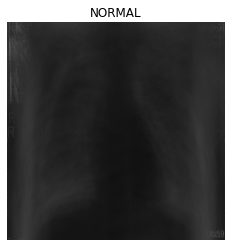

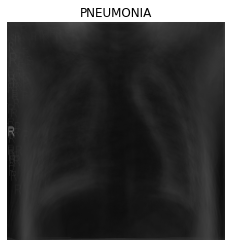

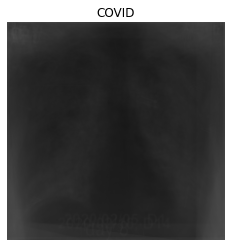

In [48]:
show_image(dev_normal, 'NORMAL')
show_image(dev_pneumonia, 'PNEUMONIA')
show_image(dev_covid, 'COVID')

#### Batching and shuffling

In [49]:
'''
input: image dataset
returns: shuffled, batched and prefetched set of images
return type: PrefetchDataset
'''
def preprocessing(dataset, buffer_size=650):
    dataset = dataset.shuffle(buffer_size=buffer_size).repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [50]:
train_set = preprocessing(train_data)
val_set = preprocessing(val_data)

In [51]:
train_set

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [52]:
sample_images, sample_targets = next(iter(train_set))

In [53]:
def visualize_samples(images, targets):
    plt.figure(figsize=(12,8))
    for n in range(16):
        sub = plt.subplot(4,4,n+1)
        plt.imshow(images[n])
        if targets[n] == 0:
            plt.title("COVID")
        elif targets[n] == 1:
            plt.title("PNEUMONIA")
        else:plt.title("NORMAL")
        plt.axis("off")

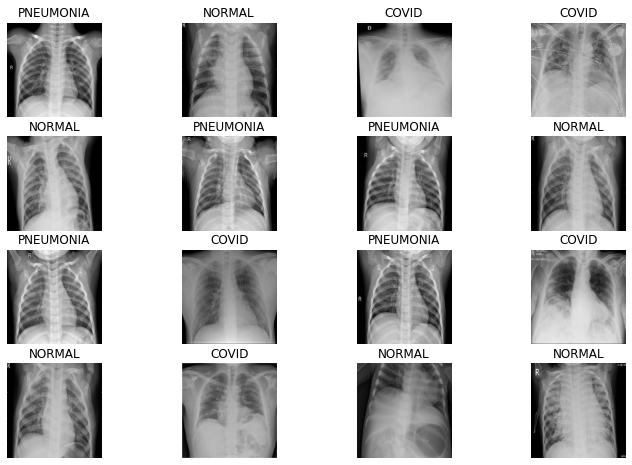

In [54]:
visualize_samples(sample_images.numpy(), sample_targets.numpy())

## Modeling

#### Base model

In [18]:
'''
convolution block with 2 separable convolution layers,
batch normalization, and max pooling
'''
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [19]:
'''
dense block with batch norm and dropout regularization
'''
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
'''
returns a sequential base model
'''
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        conv_block(256),
        tf.keras.layers.Dropout(rate=0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        
        dense_block(128, 0.5),
        dense_block(64, 0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    return model

In [21]:
# build and compile model
model = build_model()
optim = tf.keras.optimizers.Adam(learning_rate=0.0006)

model.compile(
    optimizer= optim,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
sequential (Sequential)      (None, 56, 56, 128)       27072     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 256)       103296    
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 256)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 14, 14, 256)       137216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)      

In [24]:
# callbacks for training
checkpoint = tf.keras.callbacks.ModelCheckpoint("D:/desktop/Practicum/covid_model.h5",save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10, mode='min', min_lr=1E-5)

In [31]:
# model training
# history = model.fit(
#     train_set,
#     steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
#     epochs = EPOCHS,
#     validation_data = val_set,
#     validation_steps = VAL_SIZE // BATCH_SIZE,
#     callbacks=[checkpoint]
# )

### Evaluation

In [72]:
# evaluate model on test data
model.evaluate(test_data)

7/7 [==============================] - 4s 577ms/step - loss: 0.0465 - accuracy: 0.9846


[0.04648796036573393, 0.9845758]

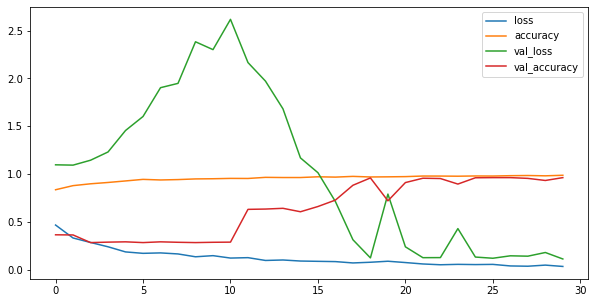

In [127]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.title('Learning curves for base model')
plt.show()

In [67]:
# unbatch test data
test_x = test_data.take(5000).map(lambda X,y: X)
test_y = test_data.take(5000).map(lambda X,y: y)
test_y = test_y.apply(tf.data.experimental.unbatch())

In [117]:
# obtaining predictions
pred = model.predict(test_x)
pred_class = np.argmax(pred, axis=1)
pred_class = pred_class.tolist()

In [118]:
# obtaining ground truth targets
y_true = []
for i in test_y.take(5000):
    y_true.append(i.numpy())

In [119]:
target_names = ['Covid', 'Normal', 'Pneumonia']

In [120]:
print(classification_report(y_true=y_true, y_pred=pred_class, target_names=target_names))

              precision    recall  f1-score   support

       Covid       1.00      0.99      1.00       124
      Normal       0.99      0.98      0.98       143
   Pneumonia       0.97      0.98      0.98       122

    accuracy                           0.98       389
   macro avg       0.98      0.98      0.98       389
weighted avg       0.98      0.98      0.98       389



### Model selection (transfer learning)

#### Inception-ResNet-V3

In [75]:
def preprocess_img_inception(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    if IMAGE_TYPE == 'png':
        img = tf.image.decode_png(img, channels=3)
    if IMAGE_TYPE == 'jpg':
        img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = inception_resnet_v2.preprocess_input(img)
    
    return img, target

In [24]:
train_data_tl = train_dataset.map(preprocess_img_inception)
val_data_tl = val_dataset.map(preprocess_img_inception)
test_data_tl = test_dataset.map(preprocess_img_inception)

In [25]:
train_set_tl = preprocessing(train_data_tl)
val_set_tl = preprocessing(val_data_tl)

In [26]:
test_set_tl = test_data_tl.batch(BATCH_SIZE)

In [27]:
inc_resnet = inception_resnet_v2.InceptionResNetV2(weights="imagenet", include_top=False)

In [28]:
inc_resnet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_5[0][0]      
________________________________________________________________________________

batch_normalization_135 (BatchN (None, None, None, 1 480         conv2d_131[0][0]                 
__________________________________________________________________________________________________
activation_130 (Activation)     (None, None, None, 1 0           batch_normalization_135[0][0]    
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, None, None, 1 208896      block17_13_ac[0][0]              
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, None, None, 1 215040      activation_130[0][0]             
__________________________________________________________________________________________________
batch_normalization_133 (BatchN (None, None, None, 1 576         conv2d_129[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [29]:
avg = tf.keras.layers.GlobalAveragePooling2D()(inc_resnet.output)
out = tf.keras.layers.Dense(3, activation='softmax')(avg)
model3 = tf.keras.Model(inputs=inc_resnet.input, outputs=out)

In [30]:
for layer in inc_resnet.layers:
    layer.trainable = False

In [31]:
optim2 = tf.keras.optimizers.Adam(learning_rate=0.2)
model3.compile(
    optimizer= optim2,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [32]:
checkpoint3 = tf.keras.callbacks.ModelCheckpoint("D:/desktop/Practicum/covid_model_inception_resnet.h5",save_best_only=True)

history3 = model3.fit(
    train_set_tl,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = 5,
    validation_data = val_set_tl,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint3]
)

Train for 87 steps, validate for 21 steps
Epoch 1/5
87/87 [==============================] - 107s 1s/step - loss: 7.7323 - accuracy: 0.7356 - val_loss: 8.2172 - val_accuracy: 0.3661
Epoch 2/5
87/87 [==============================] - 44s 507ms/step - loss: 2.6932 - accuracy: 0.8405 - val_loss: 10.5417 - val_accuracy: 0.3705
Epoch 3/5
87/87 [==============================] - 48s 548ms/step - loss: 1.6342 - accuracy: 0.8872 - val_loss: 7.3544 - val_accuracy: 0.3482
Epoch 4/5
87/87 [==============================] - 39s 453ms/step - loss: 2.4687 - accuracy: 0.8757 - val_loss: 8.9066 - val_accuracy: 0.3408
Epoch 5/5
87/87 [==============================] - 40s 454ms/step - loss: 1.4777 - accuracy: 0.9080 - val_loss: 11.6124 - val_accuracy: 0.3467


In [33]:
for layer in inc_resnet.layers:
    layer.trainable = True

In [34]:
optim3 = tf.keras.optimizers.Adam(learning_rate=0.0006)
model3.compile(
    optimizer= optim3,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [35]:
history3 = model3.fit(
    train_set_tl,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = 20,
    validation_data = val_set_tl,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint3, early_stopping, lr_scheduler]
)

Train for 87 steps, validate for 21 steps
Epoch 1/20
87/87 [==============================] - 117s 1s/step - loss: 3.5471 - accuracy: 0.9106 - val_loss: 11.1492 - val_accuracy: 0.3690
Epoch 2/20
87/87 [==============================] - 85s 982ms/step - loss: 0.2144 - accuracy: 0.9738 - val_loss: 14.8480 - val_accuracy: 0.3646
Epoch 3/20
87/87 [==============================] - 86s 985ms/step - loss: 0.0685 - accuracy: 0.9856 - val_loss: 17.7563 - val_accuracy: 0.3720
Epoch 4/20
87/87 [==============================] - 85s 977ms/step - loss: 0.0270 - accuracy: 0.9917 - val_loss: 13.7264 - val_accuracy: 0.3021
Epoch 5/20
87/87 [==============================] - 86s 983ms/step - loss: 0.0245 - accuracy: 0.9921 - val_loss: 10.5949 - val_accuracy: 0.4688
Epoch 6/20
87/87 [==============================] - 99s 1s/step - loss: 0.0150 - accuracy: 0.9935 - val_loss: 6.1795 - val_accuracy: 0.6280
Epoch 7/20
87/87 [==============================] - 85s 975ms/step - loss: 0.0291 - accuracy: 0.9914

In [36]:
model3.evaluate(test_set_tl)

13/13 [==============================] - 10s 791ms/step - loss: 0.0704 - accuracy: 0.9820


[0.07036122308542102, 0.9820051]

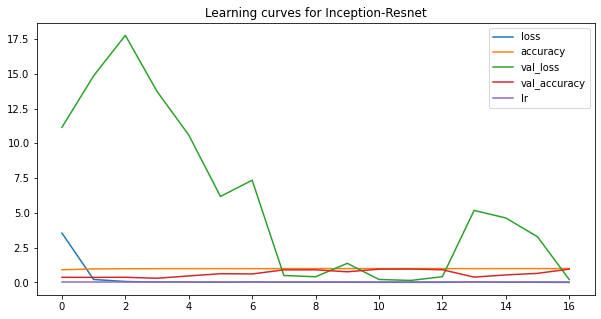

In [37]:
pd.DataFrame(history3.history).plot(figsize=(10,5))
plt.title('Learning curves for Inception-Resnet')
plt.show()

In [38]:
# unbatch test data
test_x = test_set_tl.take(5000).map(lambda X,y: X)
test_y = test_set_tl.take(5000).map(lambda X,y: y)
test_y = tf.data.Dataset.unbatch(test_y)

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


In [39]:
# obtaining predictions
pred = model3.predict(test_x)
pred_class = np.argmax(pred, axis=1)
pred_class = pred_class.tolist()

In [42]:
# obtaining ground truth targets
y_true = []
for i in test_y.take(1):
    y_true.append(i.numpy())

target_names = ['Covid', 'Normal', 'Pneumonia']

In [43]:
print(classification_report(y_true=y_true, y_pred=pred_class, target_names=target_names))

              precision    recall  f1-score   support

       Covid       0.99      1.00      1.00       124
      Normal       0.98      0.98      0.98       143
   Pneumonia       0.98      0.97      0.97       122

    accuracy                           0.98       389
   macro avg       0.98      0.98      0.98       389
weighted avg       0.98      0.98      0.98       389



#### Xception

In [25]:
def preprocess_img_xception(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
#     img = xception.preprocess_input(img)
    
    return img, target

In [26]:
train_data_tl = train_dataset.map(preprocess_img)
val_data_tl = val_dataset.map(preprocess_img)
test_data_tl = test_dataset.map(preprocess_img)

In [27]:
train_set_tl = preprocessing(train_data_tl)
val_set_tl = preprocessing(val_data_tl)

In [28]:
val_set_tl

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [29]:
test_set_tl = test_data_tl.batch(BATCH_SIZE)

In [30]:
deep_model = xception.Xception(weights="imagenet", include_top=False)

In [31]:
deep_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [32]:
avg = tf.keras.layers.GlobalAveragePooling2D()(deep_model.output)

In [33]:
out = tf.keras.layers.Dense(3, activation='softmax')(avg)

In [34]:
model2 = tf.keras.Model(inputs=deep_model.input, outputs=out)

In [35]:
for layer in deep_model.layers:
    layer.trainable = False

In [36]:
optim2 = tf.keras.optimizers.Adam(learning_rate=0.2)
model2.compile(
    optimizer= optim2,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [38]:
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(r"D:\Desktop\Practicum\Covid recognition\output\models\covid_model_deep.h5",
                                                 save_best_only=True)

history2 = model2.fit(
    train_set_tl,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = 5,
    validation_data = val_set_tl,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint2]
)

Train for 87 steps, validate for 21 steps
Epoch 1/5
87/87 [==============================] - 105s 1s/step - loss: 2.0563 - accuracy: 0.8570 - val_loss: 6.3151 - val_accuracy: 0.7336
Epoch 2/5
87/87 [==============================] - 42s 482ms/step - loss: 1.9045 - accuracy: 0.8840 - val_loss: 18.1242 - val_accuracy: 0.6176
Epoch 3/5
87/87 [==============================] - 41s 470ms/step - loss: 1.8385 - accuracy: 0.9016 - val_loss: 35.2286 - val_accuracy: 0.4509
Epoch 4/5
87/87 [==============================] - 41s 466ms/step - loss: 1.5875 - accuracy: 0.9256 - val_loss: 16.2296 - val_accuracy: 0.6443
Epoch 5/5
87/87 [==============================] - 41s 471ms/step - loss: 1.8174 - accuracy: 0.9145 - val_loss: 14.5945 - val_accuracy: 0.6771


In [39]:
for layer in deep_model.layers:
    layer.trainable = True

In [40]:
optim3 = tf.keras.optimizers.Adam(learning_rate=0.0006)
model2.compile(
    optimizer= optim3,
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [42]:
history2 = model2.fit(
    train_set_tl,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = 25,
    validation_data = val_set_tl,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint2, early_stopping, lr_scheduler]
)

Train for 87 steps, validate for 21 steps
Epoch 1/25
87/87 [==============================] - 101s 1s/step - loss: 0.9311 - accuracy: 0.6897 - val_loss: 0.9338 - val_accuracy: 0.7515
Epoch 2/25
87/87 [==============================] - 90s 1s/step - loss: 0.1827 - accuracy: 0.9580 - val_loss: 0.2370 - val_accuracy: 0.9345
Epoch 3/25
87/87 [==============================] - 86s 983ms/step - loss: 0.1001 - accuracy: 0.9871 - val_loss: 0.2446 - val_accuracy: 0.9107
Epoch 4/25
87/87 [==============================] - 85s 983ms/step - loss: 0.0490 - accuracy: 0.9935 - val_loss: 0.3016 - val_accuracy: 0.9241
Epoch 5/25
87/87 [==============================] - 90s 1s/step - loss: 0.0211 - accuracy: 0.9925 - val_loss: 0.1142 - val_accuracy: 0.9643
Epoch 6/25
87/87 [==============================] - 85s 983ms/step - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.1294 - val_accuracy: 0.9717
Epoch 7/25
87/87 [==============================] - 86s 987ms/step - loss: 0.0301 - accuracy: 0.9914 - val_l

In [43]:
model2.save(r"D:\Desktop\Practicum\Covid recognition\output\models\covid_model_deep.h5")

In [44]:
model2.evaluate(test_set_tl)

13/13 [==============================] - 15s 1s/step - loss: 0.0332 - accuracy: 0.9949


[0.03322984857200376, 0.9948586]

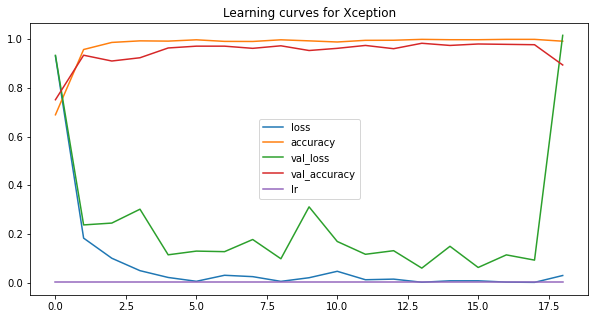

In [45]:
pd.DataFrame(history2.history).plot(figsize=(10,5))
plt.title('Learning curves for Xception')
plt.show()

In [48]:
# unbatch test data
test_x = test_set_tl.take(5000).map(lambda X,y: X)
test_y = test_set_tl.take(5000).map(lambda X,y: y)
test_y = tf.data.Dataset.unbatch(test_y)

In [49]:
# obtaining predictions
pred = model2.predict(test_x)
pred_class = np.argmax(pred, axis=1)
pred_class = pred_class.tolist()

In [ ]:
# obtaining ground truth targets
y_true = []
for i in test_y.take(5000):
    y_true.append(i.numpy())

target_names = ['Covid', 'Normal', 'Pneumonia']


In [52]:
print(classification_report(y_true=y_true, y_pred=pred_class, target_names=target_names))

              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       124
      Normal       0.99      1.00      0.99       143
   Pneumonia       1.00      0.98      0.99       122

    accuracy                           0.99       389
   macro avg       1.00      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389

